In [96]:
GC.gc() # Clear up the memory when doing a "run all" in the notebook

using Plots
gr()

include("src/load_profiles.jl")
include("src/solverFixedProdStorage.jl")
include("src/solverFixedProd.jl");

In [97]:
filename = "profiles.csv"
time_profiles, wind_profiles, solar_profiles = Dict(), Dict(), Dict()
time_profiles, wind_profiles, solar_profiles = load_profiles(filename);

## We first define the global parameters of the problem, to have consistent results

In [98]:
# Default values
D = 1000 # Kg of H2
# Battery parameters
EBAT = 0.9
CBAT = 400 # MWh
FBAT = 100 # MW
COST_BAT = 250000 * 0.0002 # € / MWh
# Electrolyzer parameters
EELEC = 0.050 # Mwh / Kg
CELEC = 1000 # MW
COST_ELEC =  1200000 * 0.0004 # € / MW
# Tank parameters
CTANK = 500 # Kg
COST_TANK = 407 # € / Kg
# Grid parameters
PRICE_GRID = 1000 # € / MWh
PRICE_CURTAILING = 1000 # € / MWh;
PRICE_PENALITY = 10; # € / times changed

10

# First Step :
## Solve the problem given the production and storage capacities

In [99]:
# We use the default values for now
D = 1000.
BAT_SIZE = 400.
TANK_SIZE = 500.
time_index = wind_profiles[2015]
wind_profile = wind_profiles[2015]
solar_profile = solar_profiles[2015]
# We decide on a mix of wind and solar
# For example, 25% of the energy comes from solar and 75% from wind
wind_share = 0.75
Total_energy_needed = D * length(wind_profile) * EELEC * 1.05 # in MWh, with a 5% safety margin
wind_capa = Total_energy_needed * wind_share / sum(wind_profile)
solar_capa = Total_energy_needed * (1 - wind_share) / sum(solar_profile);

126.3580398331975

In [100]:
output = solveFixedProdStorage(
    wind_capa,
    solar_capa,
    wind_profile,
    solar_profile,
    BAT_SIZE,
    TANK_SIZE,
    D,
    PRICE_GRID, # Grid electricity price
    PRICE_CURTAILING, # Curtailing price
    PRICE_PENALITY # Production change penality
);

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
43796 rows, 61317 cols, 140148 nonzeros
35036 rows, 52556 cols, 140142 nonzeros
35035 rows, 52554 cols, 140137 nonzeros

Solving MIP model with:
   35035 rows
   52554 cols (8759 binary, 0 integer, 0 implied int., 43795 continuous)
   140137 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   10711.070154    inf                  inf        0      0      0         0     0.3s
 S       0       0         0   0.00%   10711.070154    171212524.4485    99.99%        0      0      0         0     1.7s

Solving report
  Status            Optimal
  Primal bound      171212524.448
  Dual bound        171204141.331
  Gap               0.0049% (tolerance: 0.01%)
  Solution st

In [101]:
storage_cost = output["storage_cost"]
operating_cost = output["operating_cost"]
println("Storage cost: $storage_cost, operating cost: $operating_cost")
println("Total cost: $(storage_cost + operating_cost)")

Storage cost: 223500.0, operating cost: 1.7121252444845685e8
Total cost: 1.7143602444845685e8


In [102]:
prod_out = output["prod"]
charge_out = output["charge"]
stock_out = output["stock"]
elec_out = output["elecGrid"]
curtailment_out = output["curtail"]
consPPA_out = output["elecPPA"];

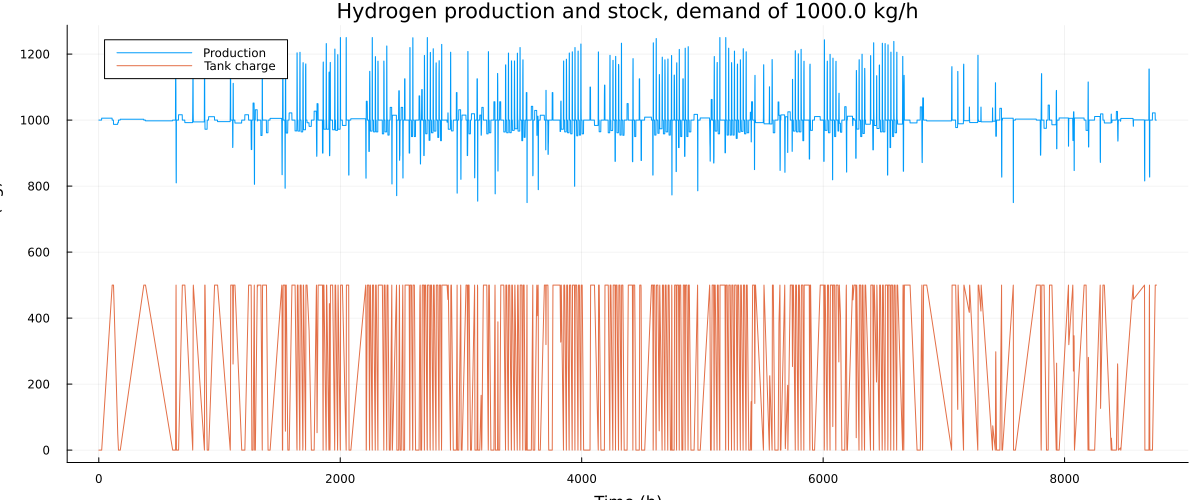

In [103]:
# Plot the production & tank charge over time
plot(size=(1200, 500), legend=:topleft, xlabel="Time (h)", ylabel="Production (Kg)", title="Hydrogen production and stock, demand of $D kg/h")
plot!(prod_out, label="Production")
plot!(stock_out, label="Tank charge")

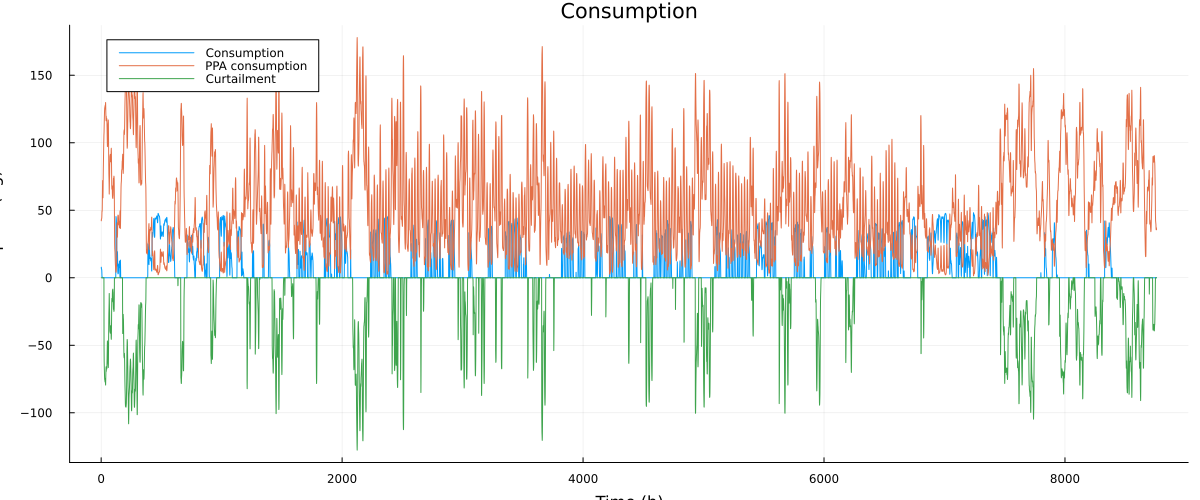

In [104]:
# Plot the consumptions, curtailment and battery charge
plot(size=(1200, 500), legend=:topleft, xlabel="Time (h)", ylabel="Consumption (Kg)", title="Consumption")
plot!(elec_out, label="Consumption")
plot!(consPPA_out, label="PPA consumption")
plot!(-curtailment_out, label="Curtailment")

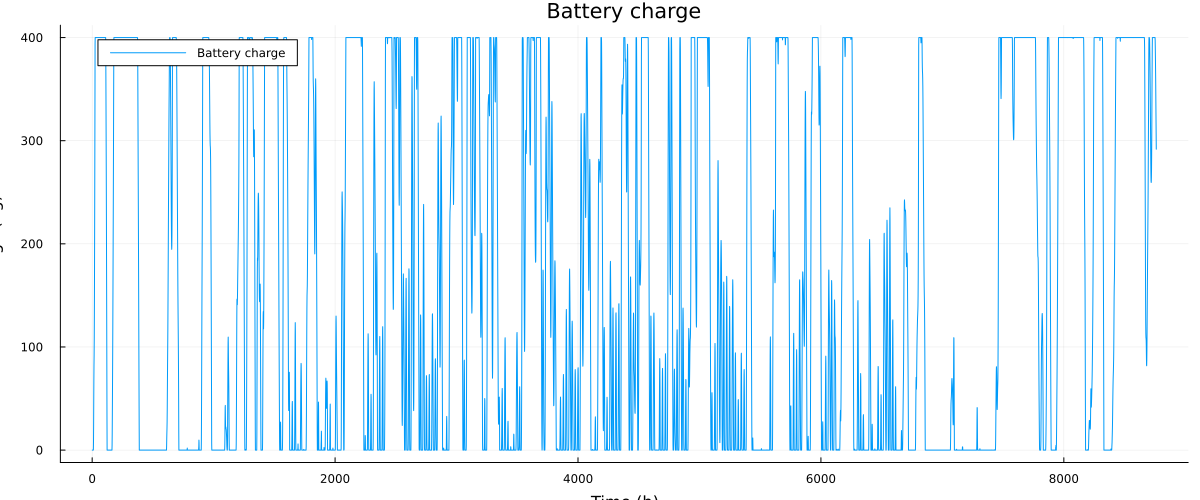

In [105]:
# Plot the battery charge
plot(size=(1200, 500), legend=:topleft, xlabel="Time (h)", ylabel="Charge (Kg)", title="Battery charge")
plot!(charge_out, label="Battery charge")

# Second Step :
## Solve the problem given the production capacities only

In [106]:
# We use the default values for now
D = 1000.
time_index = wind_profiles[2015]
wind_profile = wind_profiles[2015]
solar_profile = solar_profiles[2015]
# We decide on a mix of wind and solar
# For example, 25% of the energy comes from solar and 75% from wind
wind_share = 0.75
Total_energy_needed = D * length(wind_profile) * EELEC * 1.05 # in MWh, with a 5% safety margin
wind_capa = Total_energy_needed * wind_share / sum(wind_profile)
solar_capa = Total_energy_needed * (1 - wind_share) / sum(solar_profile);

126.3580398331975

In [107]:
output = solveFixedProd(
    wind_capa,
    solar_capa,
    wind_profile,
    solar_profile,
    D,
    1000, # Grid electricity price
    1000, # Curtailing price
    10 # Production change penality
);

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
61316 rows, 61319 cols, 175188 nonzeros
61315 rows, 61317 cols, 175184 nonzeros

Solving MIP model with:
   61315 rows
   61317 cols (8759 binary, 0 integer, 0 implied int., 52558 continuous)
   175184 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   7803.324571     inf                  inf        0      0      0         0     0.3s
 S       0       0         0   0.00%   7803.324571     17349205.195      99.96%        0      0      0         0    30.8s

Solving report
  Status            Optimal
  Primal bound      17349205.195
  Dual bound        17347822.4512
  Gap               0.00797% (tolerance: 0.01%)
  Solution status   feasible
                    1734

In [108]:
storage_cost = output["storage_cost"]
operating_cost = output["operating_cost"]
println("Storage cost: $storage_cost, operating cost: $operating_cost")
println("Total cost: $(storage_cost + operating_cost)")
battery_capa = trunc(Int64, output["battery_capa"])
tank_capa = trunc(Int64, output["tank_capa"])
println("Battery capacity: $battery_capa, Tank capacity: $tank_capa")

Storage cost: 1.6989739472407259e6, operating cost: 1.565023124775754e7
Total cost: 1.7349205194998264e7
Battery capacity: 27391, Tank capacity: 809


In [109]:
prod_out = output["prod"]
charge_out = output["charge"]
stock_out = output["stock"]
elec_out = output["elecGrid"]
curtailment_out = output["curtail"]
consPPA_out = output["elecPPA"];

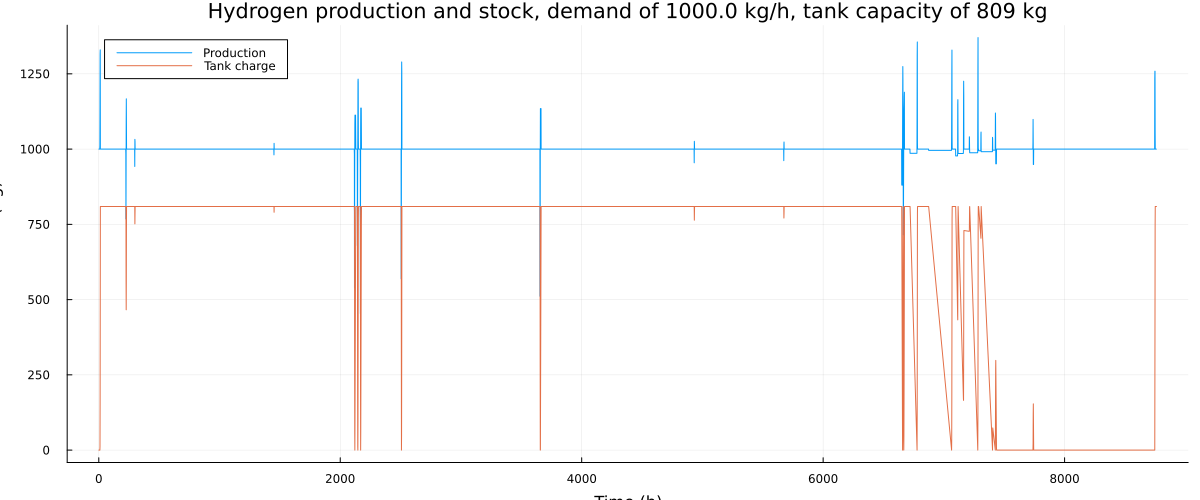

In [110]:
# Plot the production & tank charge over time
plot(size=(1200, 500), legend=:topleft, xlabel="Time (h)", ylabel="Production (Kg)", title="Hydrogen production and stock, demand of $D kg/h, tank capacity of $tank_capa kg")
plot!(prod_out, label="Production")
plot!(stock_out, label="Tank charge")

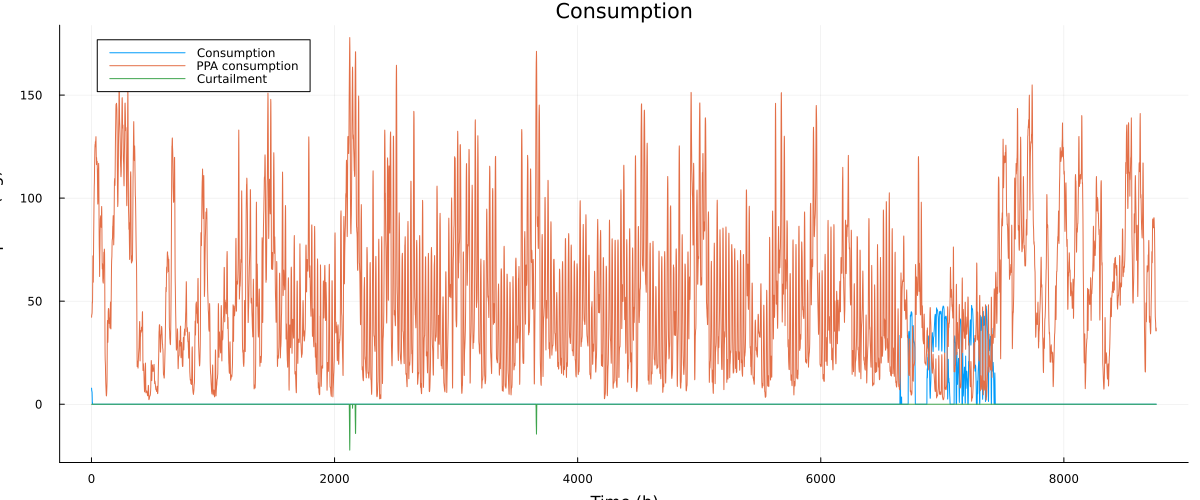

In [111]:
# Plot the consumptions, curtailment and battery charge
plot(size=(1200, 500), legend=:topleft, xlabel="Time (h)", ylabel="Consumption (Kg)", title="Consumption")
plot!(elec_out, label="Consumption")
plot!(consPPA_out, label="PPA consumption")
plot!(-curtailment_out, label="Curtailment")

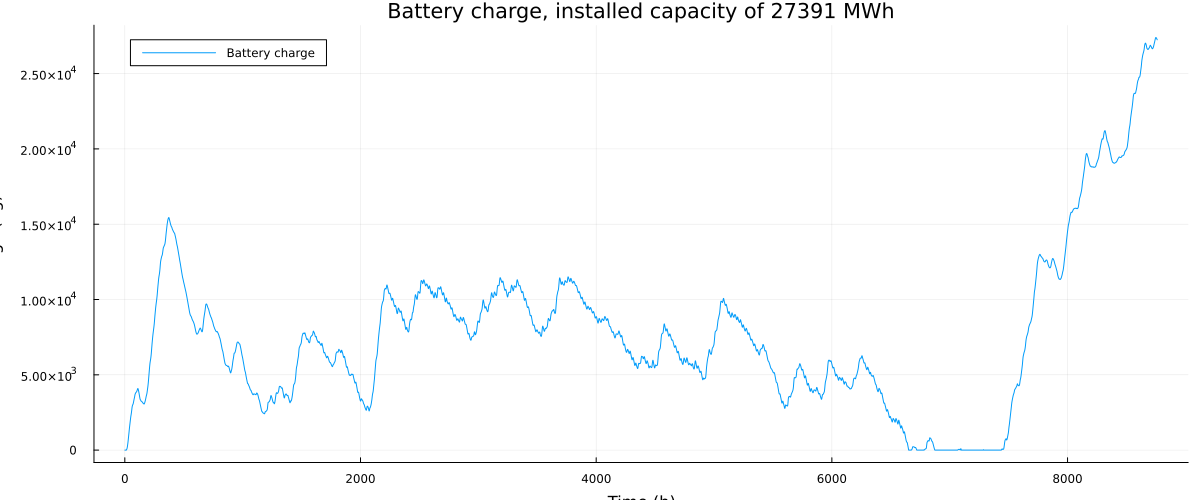

In [112]:
# Plot the battery charge
plot(size=(1200, 500), legend=:topleft, xlabel="Time (h)", ylabel="Charge (Kg)", title="Battery charge, installed capacity of $battery_capa MWh")
plot!(charge_out, label="Battery charge")